## Introduction

EcoSmart Solutions, a global consulting firm specializing in energy optimization, hired our team to analyze energy usage data for a major real estate client.
The client owns over 1,600 commercial buildings and is facing rising energy costs and carbon penalties.
Our goal is to explore the energy data, identify key patterns, and build predictive models that can help the client reduce energy waste by 20% over the next two years while maintaining building performance.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##📊 Exploratory Data Analysis (EDA)

#### Introduction

In this section, we explore the cleaned and merged dataset to understand the underlying patterns in energy consumption across different types of commercial buildings.
The focus of the analysis is twofold:

- To identify trends in energy usage by building type, time of day, and season.
- To detect any anomalies or unusual patterns that could indicate inefficiencies or opportunities for energy optimization.

Our analysis combines electricity, gas, and water consumption as indicators of total energy use.
Weather data (such as air temperature) is also incorporated to observe how external environmental factors influence building energy demand.

We begin by answering the following key questions:

1. Energy Usage Trends:
-  What types of buildings consume the most energy?

In [ ]:
## Must install spark because of the large dataset used (over 2 million rows)

# Install Java
!apt-get install openjdk-11-jdk-headless -qq > /dev/null

# Download Spark 3.3.2 (a stable archived version)
!wget -q https://archive.apache.org/dist/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz

# Extract Spark
!tar -xvzf spark-3.3.2-bin-hadoop3.tgz

# Install findspark
!pip install -q findspark


In [ ]:
import os

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"

import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("EnergyAnalysis") \
    .getOrCreate()

spark


###### Must install Spark to use the large dataset of over 2 million rows of timestamp data.

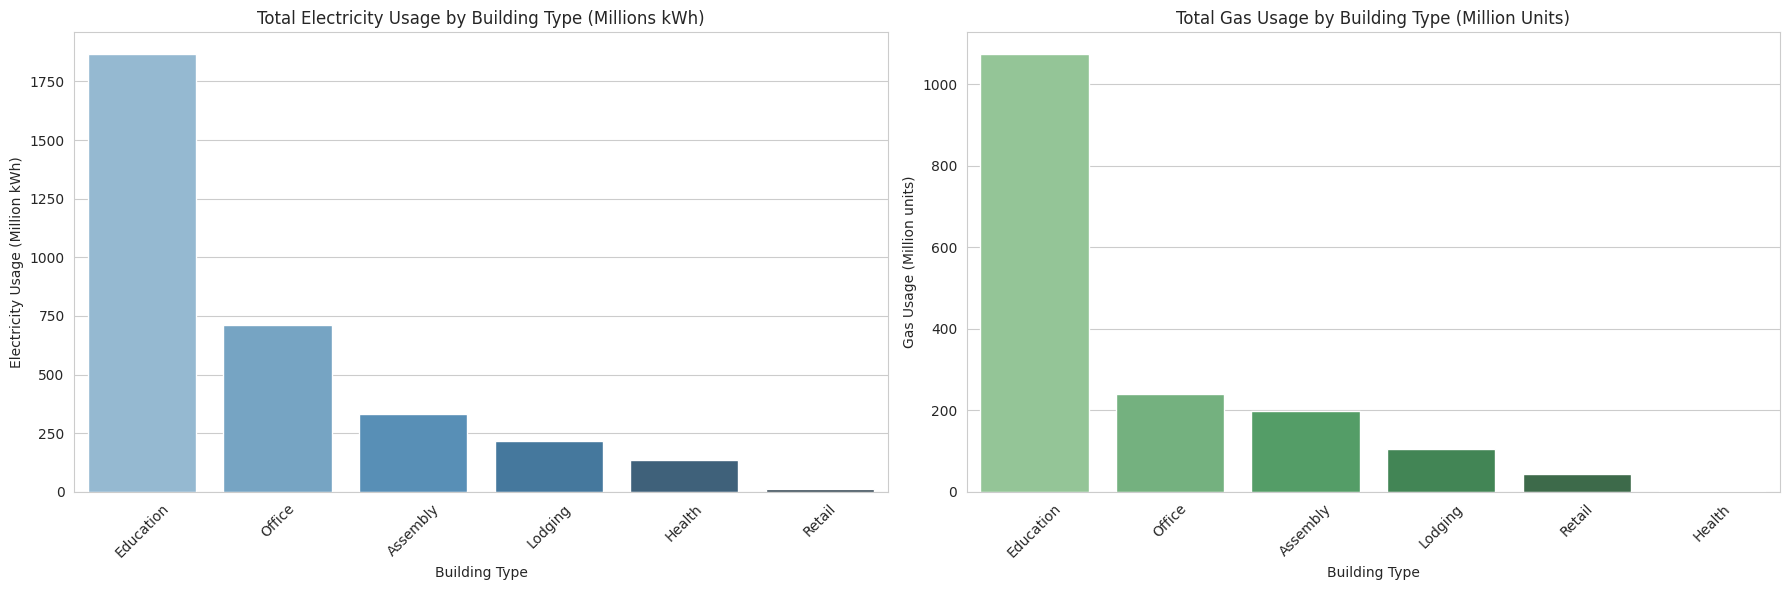

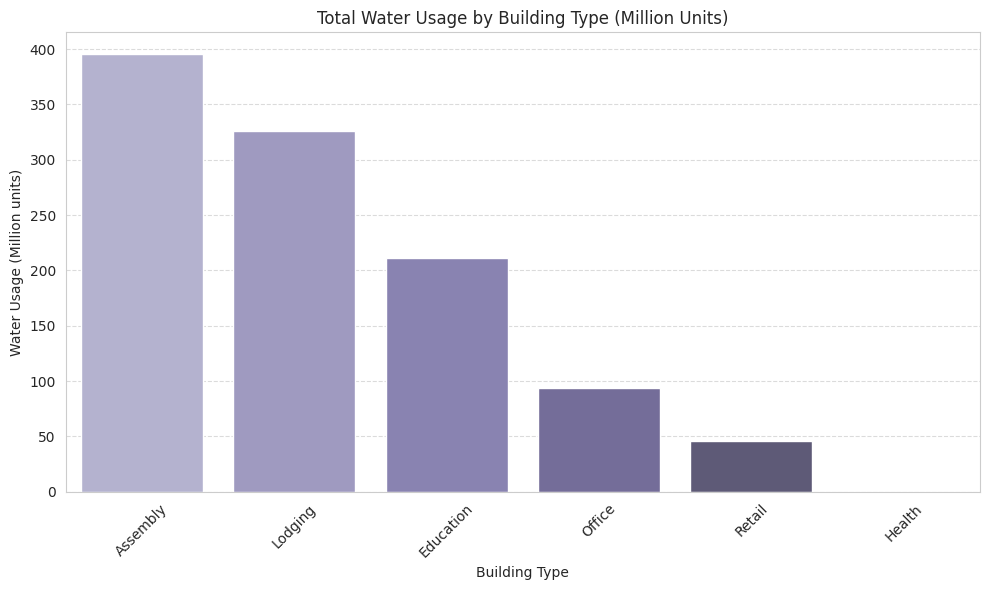

,building_type,total_electricity_kwh,total_gas_units,total_water_units
0,Education,1866.06,1073.03,211.51
1,Office,710.86,238.99,93.79
2,Assembly,331.64,198.76,395.29
3,Lodging,216.48,104.90,326.27
4,Health,133.74,1.60,NaN
5,Retail,13.03,43.99,45.92


In [ ]:
# 1. Load into Spark DataFrame
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as spark_sum
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

# Suppress only FutureWarnings (like palette without hue)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Start Spark session
spark = SparkSession.builder.appName("EnergyEDA").getOrCreate()

# Load CSV into Spark DataFrame
energy_df = spark.read.csv('/content/drive/MyDrive/BGD2_Project/final_energy_weather_with_eui.csv', header=True, inferSchema=True)

# 2. Group separately for electricity, gas, and water

# Electricity Usage
electricity_sum = (
    energy_df.groupBy('building_type')
    .agg(spark_sum('electricity_kwh').alias('total_electricity_kwh'))
    .orderBy('total_electricity_kwh', ascending=False)
)

# Gas Usage
gas_sum = (
    energy_df.groupBy('building_type')
    .agg(spark_sum('gas_units').alias('total_gas_units'))
    .orderBy('total_gas_units', ascending=False)
)

# Water Usage
water_sum = (
    energy_df.groupBy('building_type')
    .agg(spark_sum('water_units').alias('total_water_units'))
    .orderBy('total_water_units', ascending=False)
)

# 3. Collect to Pandas for plotting
electricity_pd = electricity_sum.toPandas()
gas_pd = gas_sum.toPandas()
water_pd = water_sum.toPandas()

# 4. Scale the totals to Millions for readability
electricity_pd['total_electricity_kwh'] = electricity_pd['total_electricity_kwh'] / 1_000_000
gas_pd['total_gas_units'] = gas_pd['total_gas_units'] / 1_000_000
water_pd['total_water_units'] = water_pd['total_water_units'] / 1_000_000

# 5. Plot nicely with Seaborn
sns.set_style("whitegrid")

# Create a figure with 2 side-by-side plots first (Electricity and Gas)
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Electricity
sns.barplot(
    x='building_type', y='total_electricity_kwh', data=electricity_pd,
    palette='Blues_d', ax=axes[0]
)
axes[0].set_title('Total Electricity Usage by Building Type (Millions kWh)')
axes[0].set_xlabel('Building Type')
axes[0].set_ylabel('Electricity Usage (Million kWh)')
axes[0].tick_params(axis='x', rotation=45)

# Gas
sns.barplot(
    x='building_type', y='total_gas_units', data=gas_pd,
    palette='Greens_d', ax=axes[1]
)
axes[1].set_title('Total Gas Usage by Building Type (Million Units)')
axes[1].set_xlabel('Building Type')
axes[1].set_ylabel('Gas Usage (Million units)')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Then create a second figure for Water separately
plt.figure(figsize=(10,6))
sns.barplot(
    x='building_type', y='total_water_units', data=water_pd,
    palette='Purples_d'
)
plt.title('Total Water Usage by Building Type (Million Units)')
plt.xlabel('Building Type')
plt.ylabel('Water Usage (Million units)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 6. Merge all summaries into a single table
summary = electricity_pd.merge(gas_pd, on='building_type').merge(water_pd, on='building_type')

# 7. View the final summary
import pandas as pd
summary = summary.round(2)  # Round to 2 decimal places for nicer display
summary



### Question: Which types of buildings consume the most energy?

To answer this question, we analyzed **electricity**, **gas**, and **water** consumption separately, using Spark for large data processing and visualized the results with bar charts.

We grouped the dataset by `building_type` and summed the total consumption for each resource type. To make the values easier to interpret, the totals were scaled into **millions**.



#### Findings:

##### Electricity Consumption
- **Education buildings** had the highest electricity usage, totaling approximately **1,866 million kWh**.
- **Offices** followed, consuming about **711 million kWh**.
- **Assembly** and **Lodging** buildings also showed significant, but smaller, totals.
- **Retail** buildings consumed the least electricity among all types.

##### Gas Consumption
- **Education buildings** again consumed the most gas, approximately **1,073 million gas units**.
- **Offices** and **Assembly** buildings were next in gas usage.
- **Health** buildings showed **very low gas usage**, possibly due to relying on alternative heating systems.

##### Water Consumption
- **Assembly buildings** had the highest water usage (~395 million units), **even higher than education buildings**.
- **Lodging buildings** also exhibited high water consumption (~326 million units).
- **Health buildings** had **missing water data** (NaN values), which likely lowered their overall recorded water usage.



#### Key Takeaways:
- **Education buildings** dominate **both electricity and gas consumption**, likely due to their large operational spaces and longer occupancy hours.
- **Water consumption patterns** differ: **Assembly** and **Lodging** buildings consume more water than Education buildings.
- **Retail buildings** were the **lowest consumers** across all energy categories.
- **Missing Data Impact**: Health buildings might actually have higher water usage than reported, but based on available data, they rank low in overall energy usage.




### Total Electricity Usage Over Time

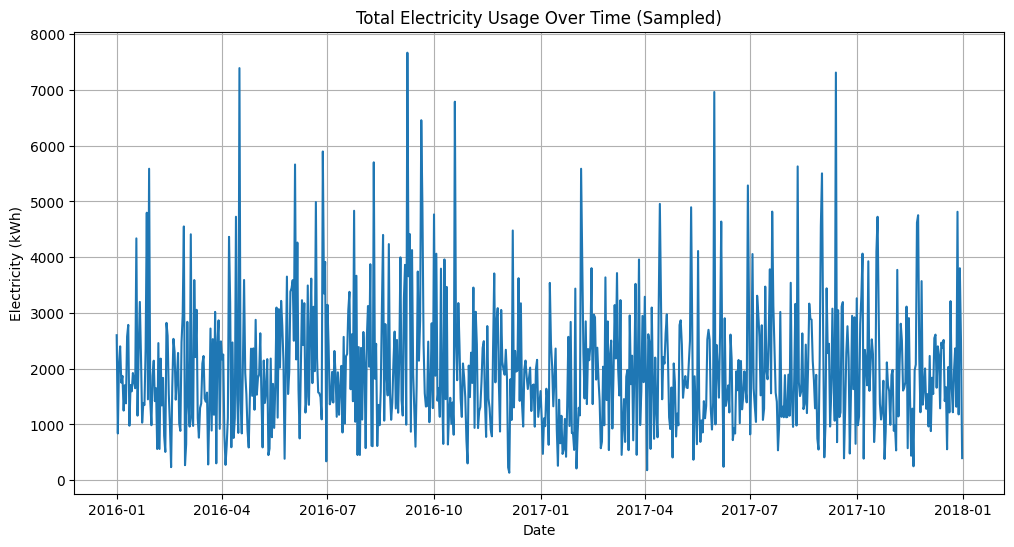

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged dataset
data = pd.read_csv('/content/drive/MyDrive/BGD2_Project/electricity_water_gas_merged.csv')

# Convert timestamp to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Sample for faster plotting. Allows to see trends and patterns rather than focusing on actual numbers.
data_sampled = data.sample(10000, random_state=42)

# Only keep necessary columns for plotting
numeric_columns = ['electricity_kwh', 'gas_units', 'water_units']

# Group by date and sum only numeric columns
daily_usage = data_sampled.groupby(data_sampled['timestamp'].dt.date)[numeric_columns].sum()

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily_usage.index, daily_usage['electricity_kwh'])
plt.title('Total Electricity Usage Over Time (Sampled)')
plt.xlabel('Date')
plt.ylabel('Electricity (kWh)')
plt.grid(True)
plt.show()


This plot shows the daily total electricity consumption across all sampled buildings from 2016 to 2017.

We observe regular fluctuations, with some seasonal peaks during the summer months and smaller peaks throughout the year.

Spikes in electricity usage may correspond to external factors such as temperature changes or operational activities.


### Total Electricity Usage by Building Type

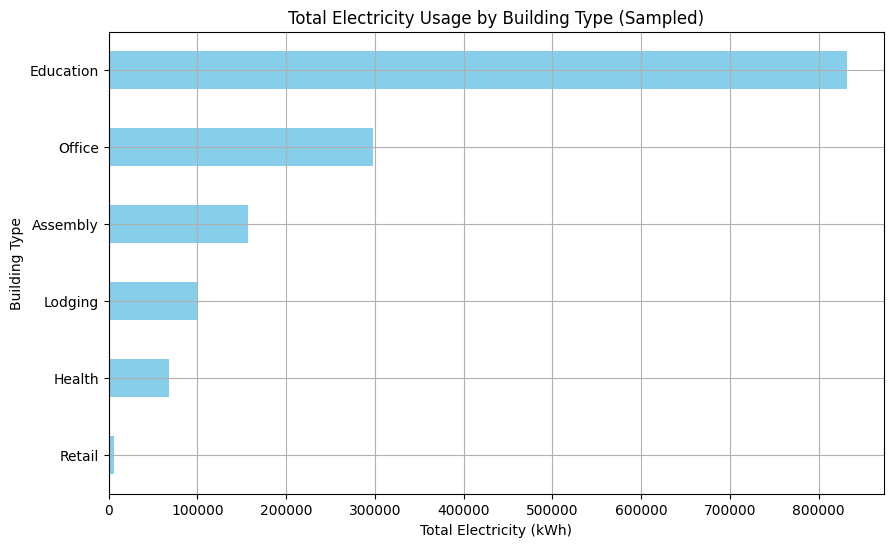

In [ ]:
# Group by building type and sum electricity usage
building_type_usage = data_sampled.groupby('building_type')['electricity_kwh'].sum().sort_values()

# Plot
plt.figure(figsize=(10,6))
building_type_usage.plot(kind='barh', color='skyblue')
plt.title('Total Electricity Usage by Building Type (Sampled)')
plt.xlabel('Total Electricity (kWh)')
plt.ylabel('Building Type')
plt.grid(True)
plt.show()

This horizontal bar chart shows the total electricity usage by building type across the sampled data.

Education and Office buildings are the highest energy consumers, followed by Assembly and Lodging types.

Retail and Health buildings show significantly lower electricity consumption.

This suggests that energy optimization efforts should prioritize Education and Office facilities first to achieve the greatest impact.

### Total Electricity Usage by Month

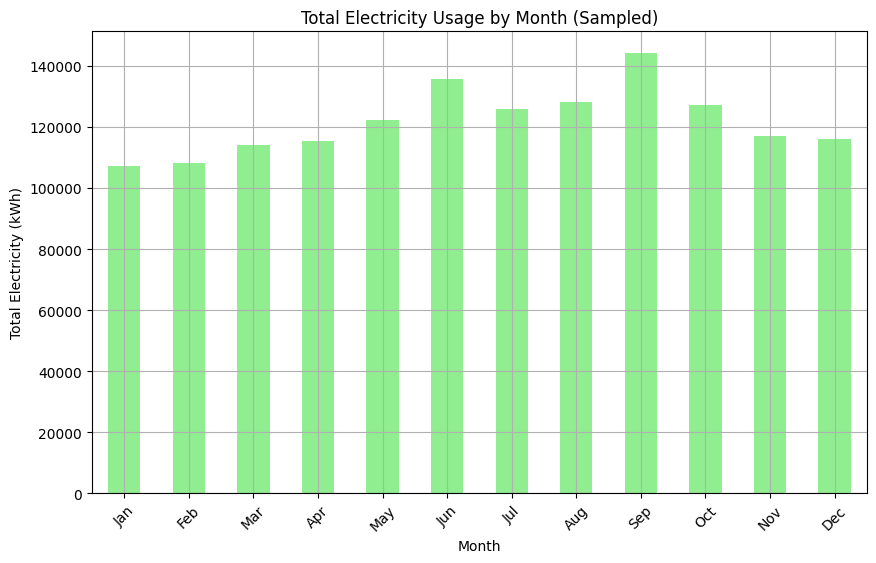

In [ ]:
# Creating a month column
data_sampled['month'] = data_sampled['timestamp'].dt.month

# Group by month and sum electricity usage
monthly_usage = data_sampled.groupby('month')['electricity_kwh'].sum()

# Plot
plt.figure(figsize=(10,6))
monthly_usage.plot(kind='bar', color='lightgreen')
plt.title('Total Electricity Usage by Month (Sampled)')
plt.xlabel('Month')
plt.ylabel('Total Electricity (kWh)')
plt.xticks(ticks=range(0,12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
plt.show()

This bar chart shows the total electricity used each month from the sample.

We can see that electricity use is higher in the summer (June to September),
most likely due to air conditioning.

It is lower in the winter and early spring.
This means the company could focus on saving energy during the busy summer months.


### Average Electricity Usage by Day of the Week

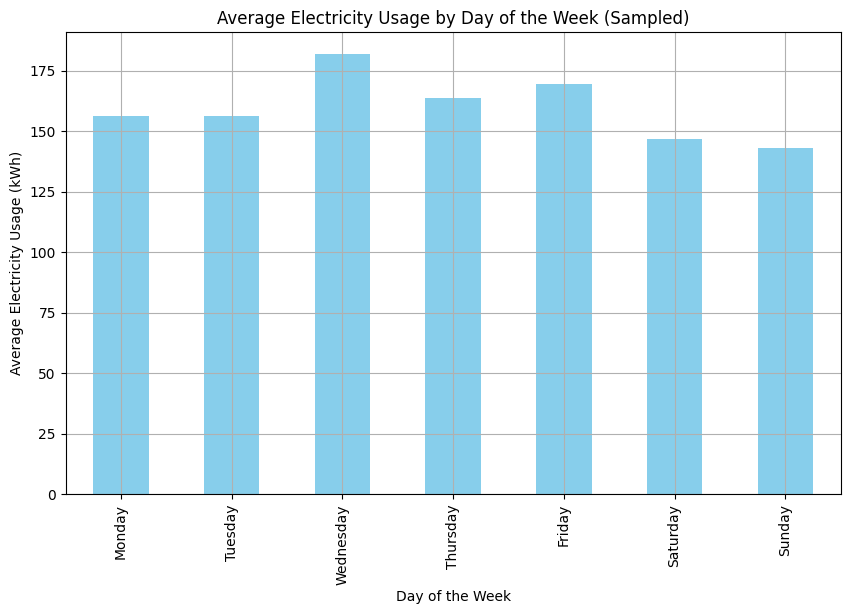

In [ ]:
# Creating a 'day of week' column
data_sampled['day_of_week'] = data_sampled['timestamp'].dt.day_name()

# Group by day of week and calculate average electricity usage
weekday_usage = data_sampled.groupby('day_of_week')['electricity_kwh'].mean()

# Order days of week correctly for easy understanding
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_usage = weekday_usage.reindex(days_order)

# Plot
plt.figure(figsize=(10,6))
weekday_usage.plot(kind='bar', color='skyblue')
plt.title('Average Electricity Usage by Day of the Week (Sampled)')
plt.xlabel('Day of the Week')
plt.ylabel('Average Electricity Usage (kWh)')
plt.grid(True)
plt.show()

This bar chart shows the average electricity used on each day of the week.

Buildings use more electricity on weekdays, especially Wednesday and Friday, and less on weekends.

This means the company could save energy by focusing on weekends when usage is lower.


### Monthly Trends in Electricity, Water, and Gas Usage by Building Type

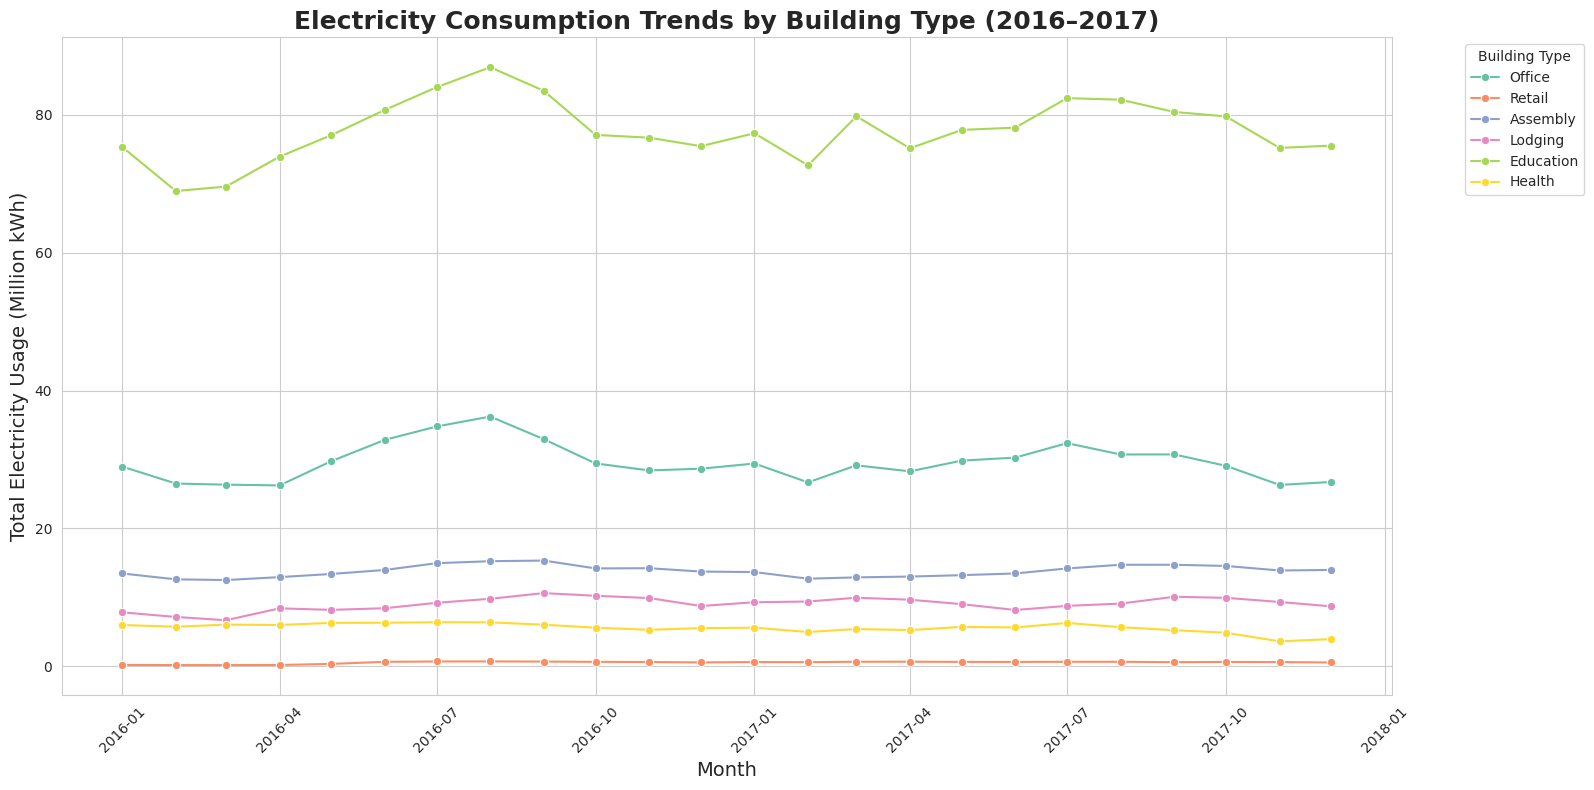

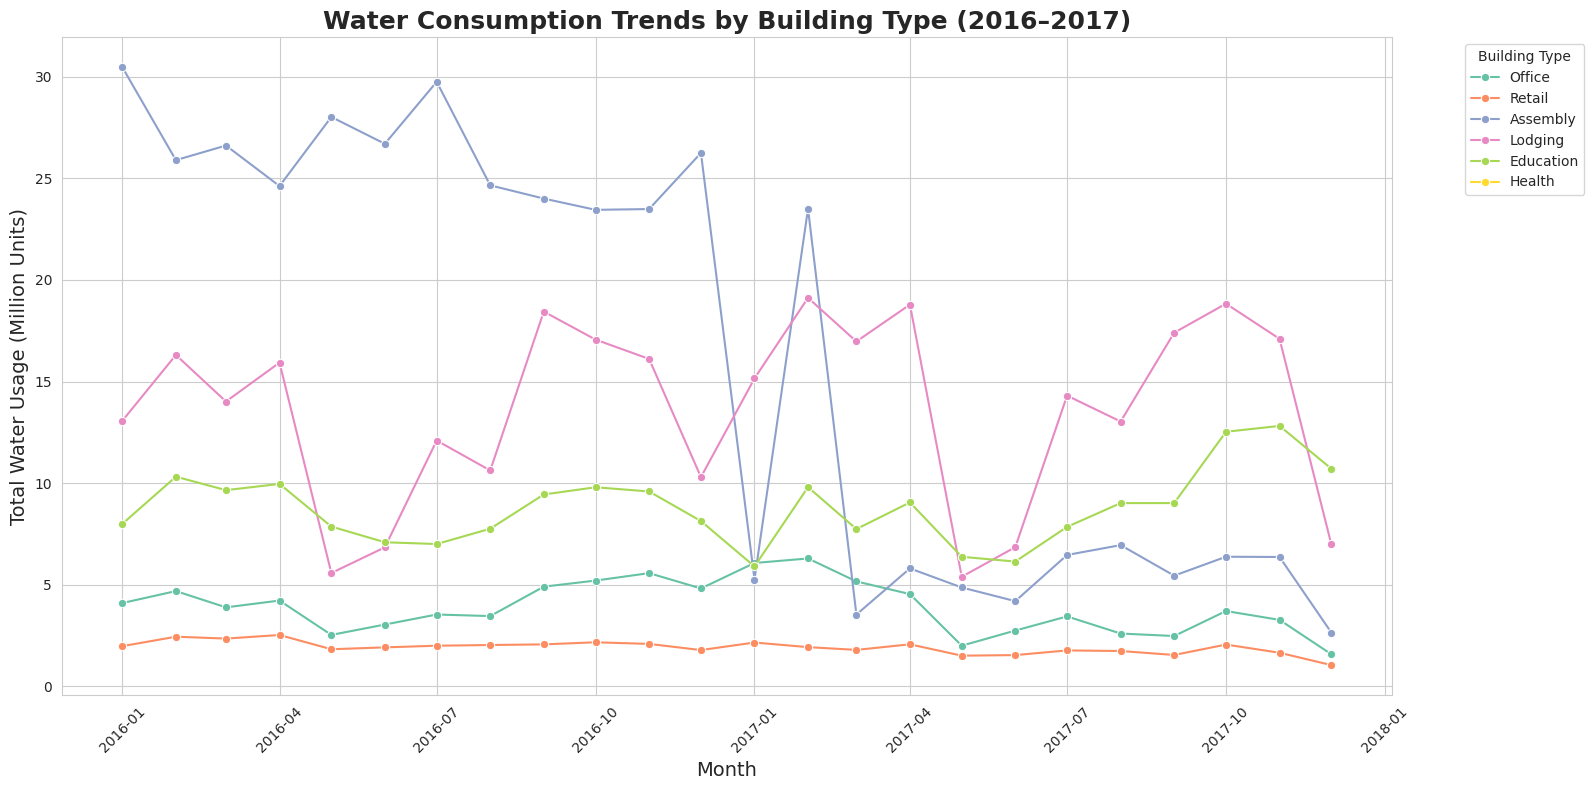

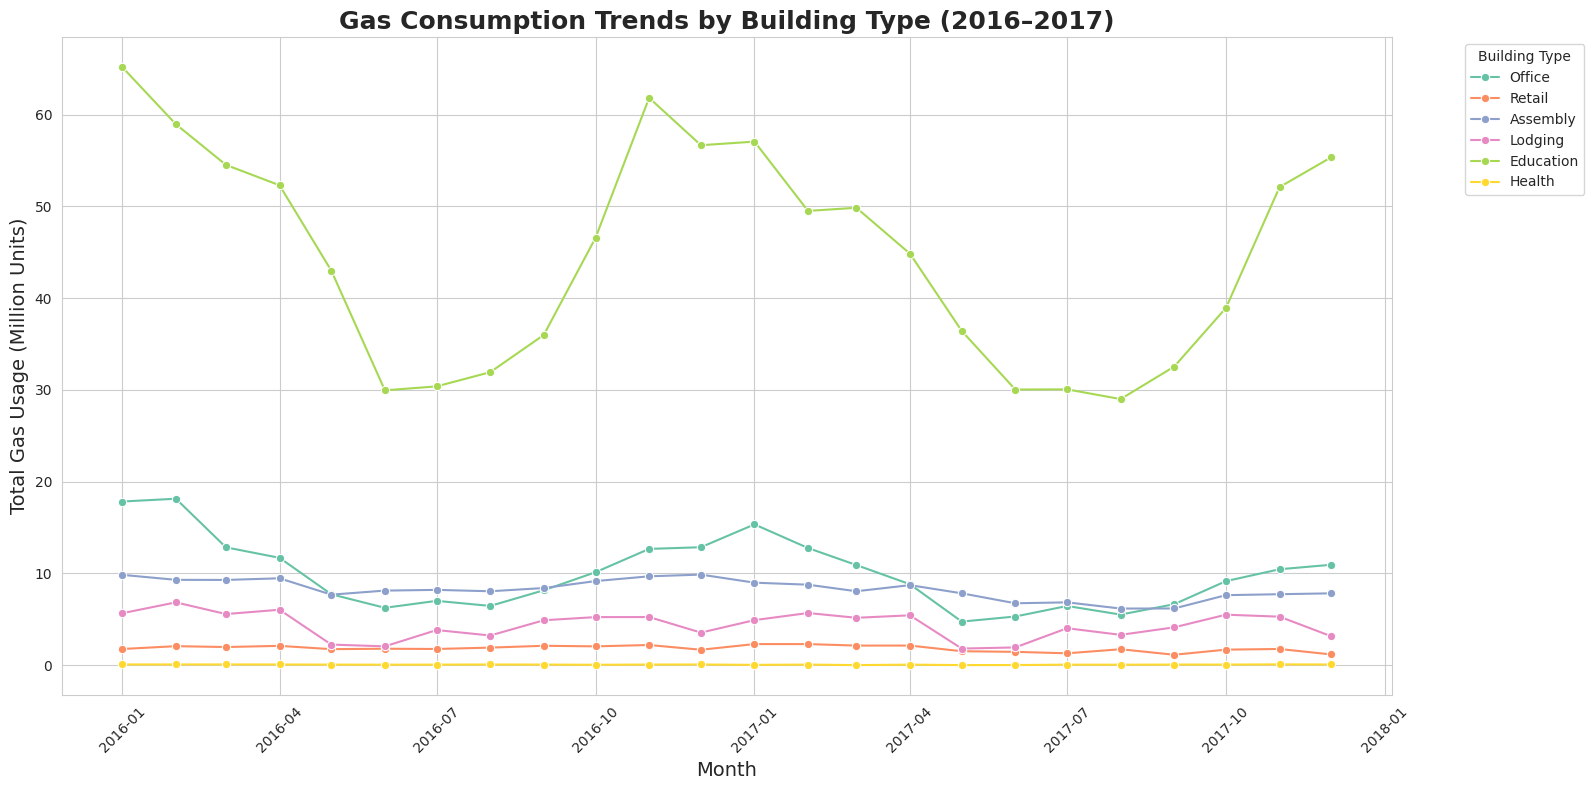

In [ ]:
# --- Imports ---
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month, sum as spark_sum, concat_ws
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import warnings

# Suppress FutureWarnings (palette + hue)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Suppress UserWarnings (palette too long)
warnings.simplefilter(action='ignore', category=UserWarning)

# --- Start Spark Session ---
spark = SparkSession.builder.appName("EnergyTrendAnalysis").getOrCreate()

# --- Load the dataset ---
energy_df = spark.read.csv('/content/drive/MyDrive/BGD2_Project/final_energy_weather_with_eui.csv', header=True, inferSchema=True)

# --- Extract year, month, and year_month columns ---
energy_df = energy_df.withColumn("year", year("timestamp"))
energy_df = energy_df.withColumn("month", month("timestamp"))
energy_df = energy_df.withColumn("year_month", concat_ws("-", energy_df["year"], energy_df["month"]))

# --- Group by building_type and year_month for each energy source ---
electricity_trends = energy_df.groupBy("building_type", "year_month").agg(
    spark_sum("electricity_kwh").alias("total_electricity")
)

water_trends = energy_df.groupBy("building_type", "year_month").agg(
    spark_sum("water_units").alias("total_water")
)

gas_trends = energy_df.groupBy("building_type", "year_month").agg(
    spark_sum("gas_units").alias("total_gas")
)

# --- Convert to Pandas for plotting ---
electricity_pd = electricity_trends.toPandas()
water_pd = water_trends.toPandas()
gas_pd = gas_trends.toPandas()

# --- Proper datetime formatting ---
for df in [electricity_pd, water_pd, gas_pd]:
    df['year_month'] = pd.to_datetime(df['year_month'], format='%Y-%m')

# --- Scale the values to millions ---
electricity_pd['total_electricity'] = electricity_pd['total_electricity'] / 1_000_000
water_pd['total_water'] = water_pd['total_water'] / 1_000_000
gas_pd['total_gas'] = gas_pd['total_gas'] / 1_000_000

# --- Set Seaborn style ---
sns.set_style("whitegrid")
palette = sns.color_palette("Set2")

# --- Plot Electricity Consumption Trends ---
plt.figure(figsize=(16,8))
sns.lineplot(
    data=electricity_pd,
    x="year_month",
    y="total_electricity",
    hue="building_type",
    marker="o",
    palette=palette
)
plt.title("Electricity Consumption Trends by Building Type (2016–2017)", fontsize=18, weight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Electricity Usage (Million kWh)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Building Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Plot Water Consumption Trends ---
plt.figure(figsize=(16,8))
sns.lineplot(
    data=water_pd,
    x="year_month",
    y="total_water",
    hue="building_type",
    marker="o",
    palette=palette
)
plt.title("Water Consumption Trends by Building Type (2016–2017)", fontsize=18, weight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Water Usage (Million Units)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Building Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- Plot Gas Consumption Trends ---
plt.figure(figsize=(16,8))
sns.lineplot(
    data=gas_pd,
    x="year_month",
    y="total_gas",
    hue="building_type",
    marker="o",
    palette=palette
)
plt.title("Gas Consumption Trends by Building Type (2016–2017)", fontsize=18, weight='bold')
plt.xlabel("Month", fontsize=14)
plt.ylabel("Total Gas Usage (Million Units)", fontsize=14)
plt.xticks(rotation=45)
plt.legend(title="Building Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### How External Factors Influence Energy Consumption Patterns

#### Overview
This analysis investigates how external factors such as **seasonality** (month of the year) and **building type** impact energy consumption patterns across three major resource types: **electricity**, **water**, and **gas**.

Using the cleaned dataset, we extracted the **year** and **month** from timestamps to create a `year_month` field. We then aggregated total resource consumption for each building type over time and plotted the trends to visualize seasonal patterns.

---

#### Key Observations

- **Electricity Usage**  
  Electricity consumption exhibits strong seasonal variation. Usage tends to **increase during summer months**, likely due to higher cooling demands (air conditioning) in certain building types such as **education** and **lodging** facilities.

- **Water Usage**  
  Water consumption shows moderate seasonal trends. Peaks often align with **warmer months**, possibly reflecting increased cooling system use, irrigation, and higher occupant activities during summer.

- **Gas Usage**  
  Gas consumption is **highest during winter months** (December to February), consistent with **heating demands** for space heating, particularly in **healthcare** and **residential** buildings.

---

#### Summary

The plots clearly demonstrate that **external factors like seasonality significantly affect energy consumption behavior** across different building types.  
Understanding these temporal patterns is crucial for optimizing energy management strategies, forecasting resource demands, and identifying opportunities for conservation measures.

These findings highlight the importance of accounting for **time-based patterns** when building predictive models or designing energy efficiency programs.
